In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("../data cleaning/FEC-itoth-2018cycle-ctc-inkind.csv", sep='|')

In [2]:
data.head()
data.shape

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI   IMAGE_NUM TRANSACTION_TP  \
0  C00035451         N     M8           P2018  1488600416            24Z   
1  C00064766         N     YE           P2018   896480183            24Z   
2  C00245548         N     YE           P2018   896523732            24Z   
3  C00359380         N     YE           P2018   896482528            24Z   
4  C00359380         N     YE           P2018   896482529            24Z   

  ENTITY_TP                     NAME        CITY STATE  ...  OCCUPATION  \
0       CCM     DONNELLY FOR INDIANA  WASHINGTON    DC  ...         NaN   
1       CCM           B.LIN CATERING  WASHINGTON    DC  ...         NaN   
2       COM     DONNELLY FOR INDIANA  WASHINGTON    DC  ...         NaN   
3       ORG  VANDALIA BUS LINES INC.  CASEYVILLE    IL  ...         NaN   
4       ORG  VANDALIA BUS LINES INC.  CASEYVILLE    IL  ...         NaN   

   TRANSACTION_DT  TRANSACTION_AMT   OTHER_ID               TRAN_ID FILE_NUM  \
0        07072015           1000.0  C00393652              13517475  1021892   
1        12102015            330.0  C00436386               B589677  1044520   
2        07292015            900.0  C00393652  B68BB3C1B1B16405390B  1044902   
3        10162015           2100.0  C00393652             SB23.6073  1044539   
4        10192015            300.0  C00393652             SB23.6075  1044539   

  MEMO_CD                                       MEMO_TEXT  \
0       X  RE-DESIGNATED FUNDS FOR TRANS. DATED 6/19/2015   
1     NaN                               IN-KIND: CATERING   
2     NaN                                             NaN   
3     NaN                                             NaN   
4     NaN                                             NaN   

                SUB_ID amt_firstdig  
0  4081820151249281986            1  
1  4012920161261311117            3  
2  4020220161261403425            9  
3  4012920161261311772            2  
4  4012920161261311773            3  

[5 rows x 22 columns]

(5735, 22)

In [16]:
data['TRANSACTION_AMT'].describe()
first_digits = data['amt_firstdig']

count    5.735000e+03
mean     1.803097e+03
std      4.772018e+04
min      1.000000e+00
25%      4.000000e+01
50%      2.080000e+02
75%      8.720000e+02
max      3.517078e+06
Name: TRANSACTION_AMT, dtype: float64

In [17]:
# Recast amt_first_digit from text to integer
# first_digits = data.loc[:,'first_dig_amt'].astype(int)

<AxesSubplot:>

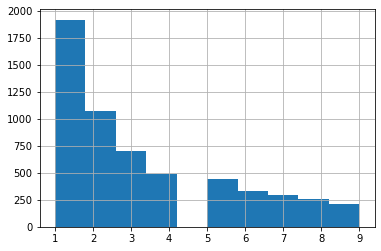

In [18]:
# Now I need to report the frequencies of each of the amt_first digits
# First, get the counts of each digit from 0 through 9
first_digits.hist()
# I wish I could get the histogram for Benford's law data

In [19]:
first_digit_counts = first_digits.value_counts().sort_index()
first_digit_counts
first_digit_counts.keys()

1    1921
2    1073
3     705
4     490
5     446
6     335
7     297
8     261
9     207
Name: amt_firstdig, dtype: int64

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [20]:
# Now get the total number of rows
total_rows = len(data)
first_digit_freq = first_digit_counts/total_rows

In [21]:
# Create Benford's limiting order distribution as a series
benfordd = pd.Series([0.30103,0.17609, 0.12494, 0.09691, 0.07918, 0.06995, 0.05799, 0.05115, 0.04576], index=range(1,10))

# [Goodness of Fit Tests](https://www.statisticshowto.com/goodness-of-fit-test/)
## [Chi-Squared Test](https://www.statisticshowto.com/probability-and-statistics/chi-square/)
First, I need to use the total number of rows to calculate the expected number of counts for each digit from Benford's distribution (expected) and compare it to first_digit_counts (observed).
The null hypothesis is that the 2018 cycle campaign finance data does follow Benford's distribution. <br>
The alternative hypothesis is that the 2018 cycle campaign finance data does not follow Benford's distributino.

In [22]:
import scipy.stats as stats

In [23]:
nrows = data.shape[0]
expected = benfordd*nrows

In [24]:
# source: https://stackoverflow.com/questions/27663924/printing-2-evenly-populated-lists-side-by-side-evenly/27663989
fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Expected', 'Observed'))
for i, (ben, cyc) in enumerate(zip(expected, first_digit_counts)):
    print(fmt.format(i, ben, cyc))

        Expected            Observed
0       1726.40705          1921
1       1009.8761499999999  1073
2       716.5309            705
3       555.77885           490
4       454.0973            446
5       401.16325           335
6       332.57265           297
7       293.34525           261
8       262.4336            207


In [25]:
stats.chisquare(f_obs=first_digit_counts, f_exp=expected)

Power_divergenceResult(statistic=63.98728507454488, pvalue=7.650617141968927e-11)

The Chi-squared statistic is 63.98 and the corresponding p-value is 7.65e-11 (basically zero). Since the p-value is less than 0.05, we reject the null hypothesis and claim that the 2018 cycle data do not follow Benford's distribution.
I need to come back and double check this!! It's very odd that the p-value is low when it appears to fit Benford's distribution so well. I should read stats.chisquare documentation more, check that my degrees of freedom are correct, and/or look at [this post](https://stackoverflow.com/questions/42888962/chi-squared-goodness-of-fit-test-in-python-way-too-low-p-values-but-the-fittin) <br>
Ahh, I should come back to it after I have all the proper data. According to Cho & Gaines on p. 220 "$\chi^2$ tests are very sensitive to sample size, having enormous power for large *N*, so that even quite small differences will be statistically significant. This test appears to be too rigid to assess goodness-of-fit well, especially since the Benford proportions do not represent a true distribution that one would expect to occur in the limit (Ley 1996; Giles 2007)."

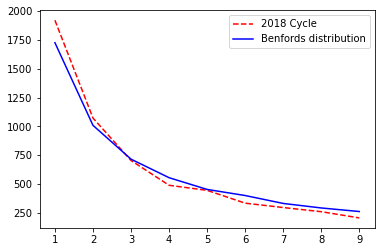

In [26]:
fig, ax = plt.subplots()
ax.plot(first_digit_counts, '--r', label='2018 Cycle')
ax.plot(expected, '-b', label='Benford''s distribution')
leg = ax.legend()

Graphically, the 2018 election cycle first digit relative frequencies look approximately the same as Benford's distribution. Very weird that it's a 'significant deviation'. Requires further investigation.

In [27]:
first_digit_freq

1    0.334961
2    0.187097
3    0.122929
4    0.085440
5    0.077768
6    0.058413
7    0.051787
8    0.045510
9    0.036094
Name: amt_firstdig, dtype: float64